In [95]:
! pip -q install pandas matplotlib
! pip install -q scikit-learn
! pip install -q joblib


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

test_df_raw = pd.read_csv("data/test.csv")
train_df_raw = pd.read_csv("data/train.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
solution_df = pd.read_csv("data/solution_example.csv")

In [97]:
# Lets quickly examine what we work with:
print(train_df_raw.head(10))
print("\n***********************Closed*Warehouses*Data***********************************\n")
print(train_calendar_df_raw.head(10))

  warehouse        date  orders holiday_name  holiday  shutdown  \
0  Prague_1  2020-12-05  6895.0          NaN        0         0   
1  Prague_1  2020-12-06  6584.0          NaN        0         0   
2  Prague_1  2020-12-07  7030.0          NaN        0         0   
3  Prague_1  2020-12-08  6550.0          NaN        0         0   
4  Prague_1  2020-12-09  6910.0          NaN        0         0   
5  Prague_1  2020-12-10  7228.0          NaN        0         0   
6  Prague_1  2020-12-11  7790.0          NaN        0         0   
7  Prague_1  2020-12-12  7165.0          NaN        0         0   
8  Prague_1  2020-12-13  6844.0          NaN        0         0   
9  Prague_1  2020-12-14  7010.0          NaN        0         0   

   mini_shutdown  shops_closed  winter_school_holidays  school_holidays  \
0              0             0                       0                0   
1              0             0                       0                0   
2              0             0       

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [119]:
unavailable_features = [
    'shutdown', 'mini_shutdown', 'blackout', 'mov_change',
    'frankfurt_shutdown', 'precipitation', 'snow', 
    'user_activity_1', 'user_activity_2'
]

In [ ]:
# Drop these features from the dataset
#train_df.drop(columns=unavailable_features)


Check both .csvs if their values in the same columns match and then merge them into one dataset

In [98]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [99]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df = merge_csv(train_df_raw, train_calendar_df_raw)
train_df.head()

{'shutdown', 'frankfurt_shutdown', 'snow', 'date', 'winter_school_holidays', 'mini_shutdown', 'holiday', 'mov_change', 'shops_closed', 'blackout', 'precipitation', 'holiday_name', 'school_holidays', 'warehouse'}
No differences found in column: shutdown
No differences found in column: frankfurt_shutdown
No differences found in column: snow
No differences found in column: winter_school_holidays
No differences found in column: mini_shutdown
No differences found in column: holiday
No differences found in column: mov_change
No differences found in column: shops_closed
No differences found in column: blackout
No differences found in column: precipitation
No differences found in column: holiday_name
No differences found in column: school_holidays

Success. All values match across the datasets, datasets merged.


,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id,warehouse_limited
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05,0
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06,0
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07,0
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08,0
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09,0


In [100]:
train_df.to_csv("data/train_merged.csv", index=False)

In [101]:
print(f"Original warehouses: {train_df.warehouse.unique()}")

Original warehouses: ['Prague_1' 'Brno_1' 'Prague_2' 'Prague_3' 'Munich_1' 'Frankfurt_1'
 'Budapest_1']


In [102]:
# Check for missing values
missing_values = train_df.isna().sum()
print(missing_values[missing_values > 0])

holiday_name     7122
precipitation     270
snow              270
dtype: int64


In [103]:
train_df.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id,warehouse_limited
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05,0
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06,0
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07,0
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08,0
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09,0


### OH encoding of categorical features

In [104]:
from sklearn.preprocessing import OneHotEncoder
import joblib

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoder on 'warehouse' and 'holiday_name' columns
encoded_features = encoder.fit_transform(train_df[['warehouse', 'holiday_name']])

# Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(['warehouse', 'holiday_name'])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)
#print(encoded_df.head())
encoded_df = encoded_df.drop(columns=['holiday_name_nan'])

# Concatenate the encoded features with the original DataFrame
#train_df = pd.concat([train_df.drop(columns=['warehouse', 'holiday_name']), encoded_df], axis=1)
train_df = pd.concat([train_df, encoded_df], axis=1)

# Save the encoder
joblib.dump(encoder, 'scaler_onehot_categorical.joblib')

c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['scaler_onehot_categorical.joblib']

### Min-Max scale numerical features

In [105]:
from sklearn.preprocessing import MinMaxScaler

# Identify numerical columns to scale
numerical_cols = ['orders', 'user_activity_1', 'user_activity_2']

# Identify numerical columns to scale
weather_cols = ['precipitation', 'snow']

# Initialize the scaler
num_scaler = MinMaxScaler()
wet_scaler = MinMaxScaler()

# Fit the scaler on the numerical columns
train_df[numerical_cols] = num_scaler.fit_transform(train_df[numerical_cols])
# Fit the scaler on the numerical columns
train_df[weather_cols] = wet_scaler.fit_transform(train_df[weather_cols])

# Save the scaler
joblib.dump(num_scaler, 'scaler_minmax_numerical.joblib')
joblib.dump(wet_scaler, 'scaler_minmax_weather.joblib')

['scaler_minmax_weather.joblib']

In [106]:
train_df.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id,warehouse_limited,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day
0,Prague_1,2020-12-05,0.351893,NaN,0,0,0,0,0,0,0,0.0,0,0.00000,0.0,0.419628,0.699945,Prague_1_2020-12-05,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Prague_1,2020-12-06,0.333967,NaN,0,0,0,0,0,0,0,0.0,0,0.00000,0.0,0.408122,0.698399,Prague_1_2020-12-06,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Prague_1,2020-12-07,0.359675,NaN,0,0,0,0,0,0,0,0.0,0,0.00000,0.0,0.410829,0.699422,Prague_1_2020-12-07,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Prague_1,2020-12-08,0.332008,NaN,0,0,0,0,0,0,0,0.0,0,0.01000,0.0,0.405753,0.696489,Prague_1_2020-12-08,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Prague_1,2020-12-09,0.352758,NaN,0,0,0,0,0,0,0,0.0,0,0.00625,0.0,0.413536,0.696193,Prague_1_2020-12-09,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
train_df.to_csv("data/train_preprocessed.csv", index=False)

### Process the Date

In [108]:
train_df["date"]

0       2020-12-05
1       2020-12-06
2       2020-12-07
3       2020-12-08
4       2020-12-09
           ...    
7335    2024-03-10
7336    2024-03-11
7337    2024-03-12
7338    2024-03-13
7339    2024-03-14
Name: date, Length: 7340, dtype: object

In [109]:
def process_date(df):
    df['date'] = pd.to_datetime(df['date'])
    df.index = df.pop('date')
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

In [110]:
process_date(train_df)
train_df.head()

,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id,warehouse_limited,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,year,month,day,day_of_week,is_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,0.351893,NaN,0,0,0,0,0,0,0,0.0,0,0.00000,0.0,0.419628,0.699945,Prague_1_2020-12-05,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,5,5,1
2020-12-06,Prague_1,0.333967,NaN,0,0,0,0,0,0,0,0.0,0,0.00000,0.0,0.408122,0.698399,Prague_1_2020-12-06,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,6,6,1
2020-12-07,Prague_1,0.359675,NaN,0,0,0,0,0,0,0,0.0,0,0.00000,0.0,0.410829,0.699422,Prague_1_2020-12-07,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,7,0,0
2020-12-08,Prague_1,0.332008,NaN,0,0,0,0,0,0,0,0.0,0,0.01000,0.0,0.405753,0.696489,Prague_1_2020-12-08,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,8,1,0
2020-12-09,Prague_1,0.352758,NaN,0,0,0,0,0,0,0,0.0,0,0.00625,0.0,0.413536,0.696193,Prague_1_2020-12-09,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,9,2,0


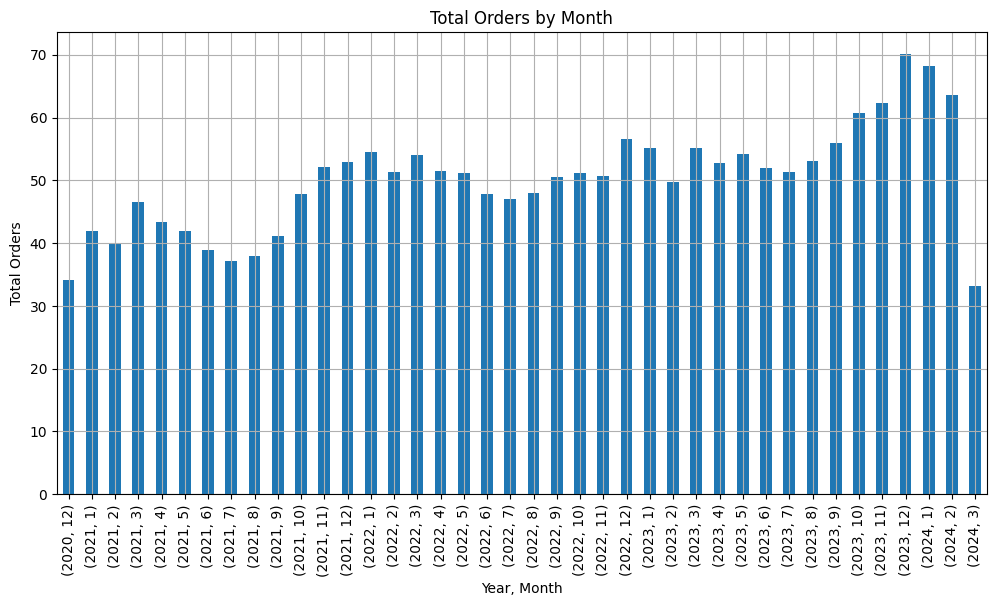

In [111]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

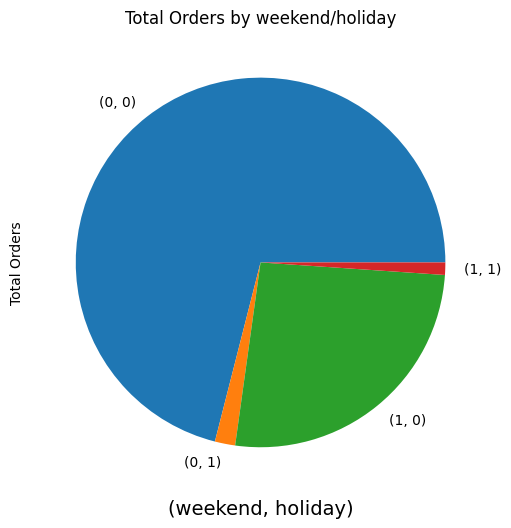

In [112]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

### Compare feature Colerations

In [113]:
train_df_corr = train_df.drop(columns=['id', 'warehouse', 'holiday_name']).corr()

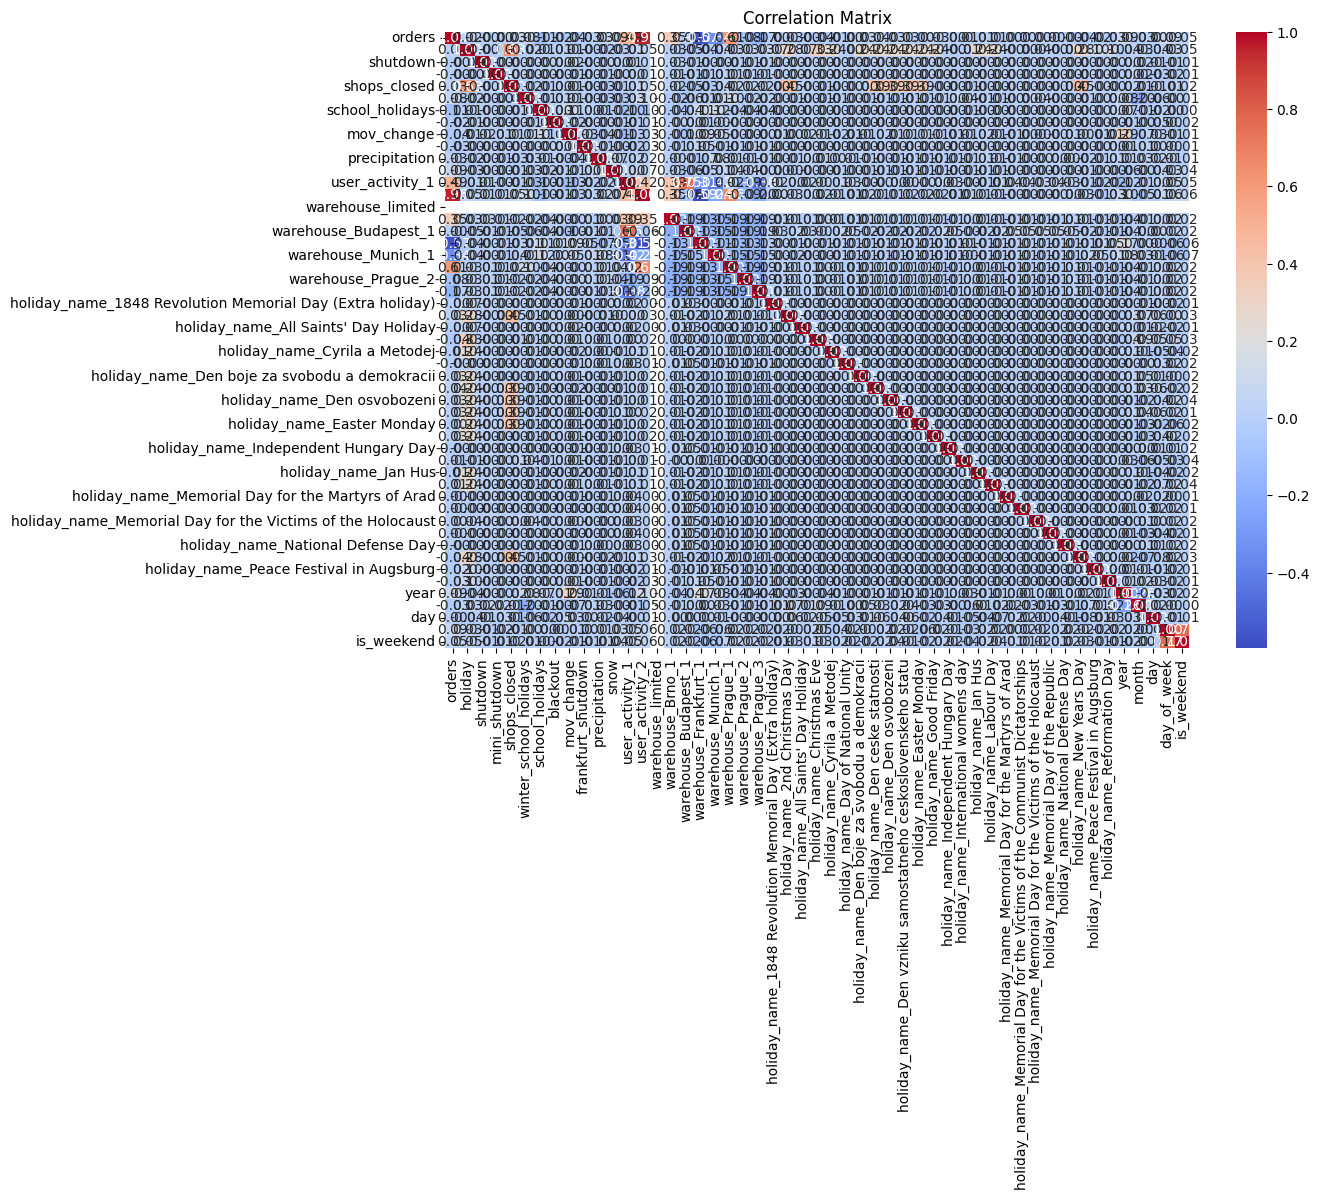

orders                                                                      1.000000
user_activity_2                                                             0.960245
warehouse_Prague_1                                                          0.605527
user_activity_1                                                             0.488895
warehouse_Brno_1                                                            0.351034
snow                                                                        0.093424
day_of_week                                                                 0.086522
year                                                                        0.085920
winter_school_holidays                                                      0.077211
is_weekend                                                                  0.046594
holiday_name_Den ceske statnosti                                            0.039121
shops_closed                                                     

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

In [115]:
train_df.head()

,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id,warehouse_limited,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,year,month,day,day_of_week,is_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,0.351893,NaN,0,0,0,0,0,0,0,0.0,0,0.00000,0.0,0.419628,0.699945,Prague_1_2020-12-05,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,5,5,1
2020-12-06,Prague_1,0.333967,NaN,0,0,0,0,0,0,0,0.0,0,0.00000,0.0,0.408122,0.698399,Prague_1_2020-12-06,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,6,6,1
2020-12-07,Prague_1,0.359675,NaN,0,0,0,0,0,0,0,0.0,0,0.00000,0.0,0.410829,0.699422,Prague_1_2020-12-07,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,7,0,0
2020-12-08,Prague_1,0.332008,NaN,0,0,0,0,0,0,0,0.0,0,0.01000,0.0,0.405753,0.696489,Prague_1_2020-12-08,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,8,1,0
2020-12-09,Prague_1,0.352758,NaN,0,0,0,0,0,0,0,0.0,0,0.00625,0.0,0.413536,0.696193,Prague_1_2020-12-09,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,9,2,0


### Add Lag and Rolling window features

In [ ]:
# Generate lag and rolling features
def create_lag_features(df, lag_days, target_col='orders'):
    for lag in lag_days:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, window_sizes, target_col='orders'):
    for window in window_sizes:
        df[f'rolling_mean_{window}'] = df[target_col].shift(1).rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df[target_col].shift(1).rolling(window=window).std()
    return df

In [ ]:
lag_days = [1, 7, 14]
window_sizes = [7, 14]
df_processed = create_lag_features(df_processed, lag_days)
df_processed = create_rolling_features(df_processed, window_sizes)

# Fill missing values resulting from lag features
df_processed.fillna(0, inplace=True)

print(df.head())

### Load Dataset

In [ ]:
train_df.drop(columns=['warehouse', 'holiday_name', 'id'], inplace=True)

In [117]:
X = train_df.drop(columns='orders')
y = train_df['orders']

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


### Compile and Fit the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape data for LSTM [samples, timesteps, features]
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_val_lstm, y_val))


In [ ]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()